In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from wandb.keras import WandbCallback

In [2]:
def plot_2d_data(data_2d, titles=None, figsize = (7, 7)):
  _, axs = plt.subplots(1, len(data_2d), figsize = figsize)

  for i in range(len(data_2d)):
    
    if (titles != None):
      axs[i].set_title(titles[i])
    scatter=axs[i].scatter(data_2d[i][:, 0], data_2d[i][:, 1], s=1,
                             cmap=plt.cm.Paired)
    wandb.log({"Embdedding": wandb.Image(plt)})

def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')
    
  wandb.log({"Training": wandb.Image(plt)})

def plot_generated_images(generated_images, nrows, ncols,no_space_between_plots=False, figsize=(10, 10)):
  _, axs = plt.subplots(nrows, ncols,figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      axs[i,j].imshow(generated_images[i][j], cmap='gray')

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)
  

  plt.show()

In [3]:
import os 
import numpy as np 
from imageio import imread, imsave
from PIL import Image


def load_dataset(name, root_folder):
    data_folder = os.path.join(root_folder, name)
    if name.lower() == 'celeba':
        x = np.load(os.path.join(data_folder, 'train.npy'))
        side_length = 64
        channels = 3
    else:
        raise Exception('No such dataset called {}.'.format(name))
    return x, side_length, channels


def load_test_dataset(name, root_folder):
    data_folder = os.path.join(root_folder, name)
   
    if name.lower() == 'celeba':
        x = np.load(os.path.join(data_folder, 'test.npy'))
        side_length = 64
        channels = 3
    else:
        raise Exception('No such dataset called {}.'.format(name))
    return x, side_length, channels


def load_val_dataset(name, root_folder):
    data_folder = os.path.join(root_folder, name)
   
    if name.lower() == 'celeba':
        x = np.load(os.path.join(data_folder, 'val.npy'))
        side_length = 64
        channels = 3
    else:
        raise Exception('No such dataset called {}.'.format(name))
    return x, side_length, channels

In [4]:
category_count = 40

train_x, _, _ = load_dataset("celeba", "datasets")
test_x, _, _ = load_test_dataset("celeba", "datasets")
val_x, _, _ = load_val_dataset("celeba", "datasets")

train_x = train_x/255.0
test_x = test_x/255.0
val_x = val_x/255.0


print('Min value: ',train_x.min())

print('Max value: ',train_x.max())

Min value:  0.0
Max value:  1.0


In [5]:
import pandas as pd
file_path = "datasets/list_attr_celeba.csv"
df = pd.read_csv(file_path, header = 0, index_col = 0).replace(-1,0)

df.shape

(202599, 40)

In [6]:
train_y = np.array(df.iloc[ 0: 162770], dtype = "float32")
print(train_y.shape)
print(train_x.shape)

test_y = np.array(df.iloc[182637: 202599], dtype = "float32")
print(test_y.shape)
print(test_x.shape)

val_y = np.array(df.iloc[162770: 182637], dtype = "float32")
print(val_y.shape)
print(val_x.shape)

(162770, 40)
(162770, 64, 64, 3)
(19962, 40)
(19962, 64, 64, 3)
(19867, 40)
(19867, 64, 64, 3)


In [7]:
train_x = np.array(train_x, dtype = "float")
test_x = np.array(test_x, dtype = "float")
val_x = np.array(val_x, dtype = "float")

In [8]:
# TO DO: sample?

train_x = train_x[:100000,:, :, :]
train_y = train_y[:100000, :]

test_x = test_x[:19000,:, :, :]
test_y = test_y[:19000, :]

val_x = val_x[:19000, :, :, :]
val_y = val_y[:19000, :]


In [9]:
print('Min value: ',train_x.min())
print('Max value: ',train_x.max())

Min value:  0.0
Max value:  1.0


In [10]:
original_image_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])

train_x_flatten=np.reshape(train_x,(train_x.shape[0],-1))
val_x_flatten=np.reshape(val_x,(val_x.shape[0],-1))
test_x_flatten=np.reshape(test_x,(test_x.shape[0],-1))

print('Train data flatten shape: ',train_x_flatten.shape)
print('Validation data flatten shape: ',val_x_flatten.shape)
print('Test data flatten shape: ',test_x_flatten.shape)

Train data flatten shape:  (100000, 12288)
Validation data flatten shape:  (19000, 12288)
Test data flatten shape:  (19000, 12288)


In [11]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape=(batch_size, dim), mean=0., stddev=1.0)
    return K.exp(0.5 * log_var) * epsilon + mu

In [12]:
train_y_one_hot = train_y
val_y_one_hot=val_y
test_y_one_hot=test_y

print('Train label one hot encoding shape: ',train_y_one_hot.shape)
print('Validation label one hot encoding shape: ',val_y_one_hot.shape)
print('Test label one hot encoding shape: ',test_y_one_hot.shape)

Train label one hot encoding shape:  (100000, 40)
Validation label one hot encoding shape:  (19000, 40)
Test label one hot encoding shape:  (19000, 40)


In [13]:
import wandb

wandb.init(project="HistoDL", entity="nrderus",
  config = {
  "dataset": "CelebA",
  "model": "CVAE-Dense",
  "encoded_dim": 4,
  "kl_coefficient": 1,
  "learning_rate": 0.01,
  "epochs": 100,
  "batch_size": 100,
  "patience": 5,
  
})
encoded_dim = wandb.config.encoded_dim


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrderus. Use `wandb login --relogin` to force relogin


In [14]:
def build_cvae(input_count,condition_count,neuron_count_per_hidden_layer,encoded_dim,hidden_activation,output_activation):
    input_data=layers.Input(shape=input_count, name='input_data')
    input_condition=layers.Input(shape=condition_count, name='input_condition')
    
    #Encoder
    encoder_input = layers.Concatenate(name='encoder_input')([input_data, input_condition])
        
    prev_layer=encoder_input
    for neuron_count in neuron_count_per_hidden_layer:
      hidden_layer=layers.Dense(neuron_count,activation=hidden_activation)(prev_layer)
      prev_layer=hidden_layer
    
    mu = layers.Dense(encoded_dim, name='mu')(prev_layer)
    log_var = layers.Dense(encoded_dim, name='log_var')(prev_layer)
    
    encoder = keras.Model([input_data,input_condition], [mu, log_var], name='encoder')

    #Decoder
    decoder_input_sample = layers.Input(shape=(encoded_dim,), name='decoder_input_sample')
    decoder_input = layers.Concatenate(name='decoder_input')([decoder_input_sample, input_condition])

    prev_layer=decoder_input
    for neuron_count in reversed(neuron_count_per_hidden_layer):
      hidden_layer=layers.Dense(neuron_count,activation=hidden_activation)(prev_layer)
      prev_layer=hidden_layer
    
    decoder_output_layer=layers.Dense(input_count,activation=output_activation, name='decoder_output')(prev_layer)

    decoder = keras.Model([decoder_input_sample,input_condition], decoder_output_layer, name='decoder')

    #Sampling layer
    s = layers.Lambda(sampling, output_shape=(encoded_dim,), name='s')([mu, log_var])

    #CVAE
    cvae=keras.Model(encoder.input, decoder([s,input_condition]),name='cvae')
        
    return cvae,encoder,decoder

In [15]:
cvae, cvae_encoder, cvae_decoder=build_cvae(train_x_flatten.shape[1],category_count,[512, 256,128],encoded_dim,'sigmoid','sigmoid')

2022-07-01 19:15:16.728758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 12288)]      0           []                               
                                                                                                  
 input_condition (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 encoder_input (Concatenate)    (None, 12328)        0           ['input_data[0][0]',             
                                                                  'input_condition[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 512)          6312448     ['encoder_input[0][0]']       

In [17]:
cvae_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 12288)]      0           []                               
                                                                                                  
 input_condition (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 encoder_input (Concatenate)    (None, 12328)        0           ['input_data[0][0]',             
                                                                  'input_condition[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 512)          6312448     ['encoder_input[0][0]']    

In [18]:
cvae_decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input_sample (InputLay  [(None, 4)]         0           []                               
 er)                                                                                              
                                                                                                  
 input_condition (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 decoder_input (Concatenate)    (None, 44)           0           ['decoder_input_sample[0][0]',   
                                                                  'input_condition[0][0]']        
                                                                                            

In [19]:
def vae_loss(vae_input,vae_ouput,mu,log_var,kl_coefficient):
  #Reconstruction loss
  reconstruction_loss = keras.losses.mean_squared_error(vae_input,vae_ouput) * train_x_flatten.shape[1]

  #Regularization loss
  kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)

  #Combined loss
  return reconstruction_loss + kl_coefficient*kl_loss

In [20]:
kl_coefficient=1
cvae_input=cvae.input[0]
cvae_output=cvae.output
mu=cvae.get_layer('mu').output
log_var=cvae.get_layer('log_var').output

cvae.add_loss(vae_loss(cvae_input,cvae_output,mu,log_var,kl_coefficient))
learning_rate = 0.001
cvae.compile(keras.optimizers.Adam(learning_rate = learning_rate))

In [21]:
epoch_count = 100
batch_size=100
patience= 10

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = cvae.fit([train_x_flatten,train_y_one_hot],
                   validation_data=([val_x_flatten,val_y_one_hot],None),
                   epochs=epoch_count,
                   batch_size=batch_size,
                   callbacks=[early_stop])

Epoch 1/2
1000/1000 [==============================] - 39s 38ms/step - loss: 715.2217 - val_loss: 710.7635
Epoch 2/2
1000/1000 [==============================] - 36s 36ms/step - loss: 713.8205 - val_loss: 710.7379


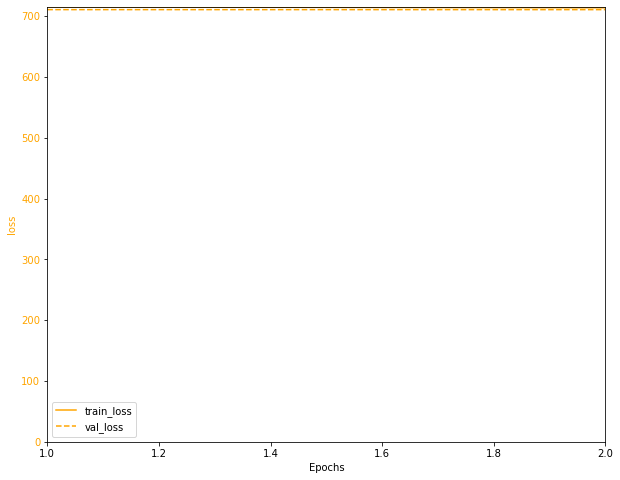

In [22]:
plot_history(history)

In [23]:
wandb.log({
         'loss': round(history.history['loss'][0],2),
        'val_loss': round(history.history['val_loss'][0],2)})

In [24]:
train_x_latent, _= cvae_encoder.predict([train_x_flatten[:15000],train_y_one_hot[:15000]])
val_x_latent, _ = cvae_encoder.predict([val_x_flatten[:15000],val_y_one_hot[:15000]])
test_x_latent, _ = cvae_encoder.predict([test_x_flatten[:15000],test_y_one_hot[:15000]])

/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

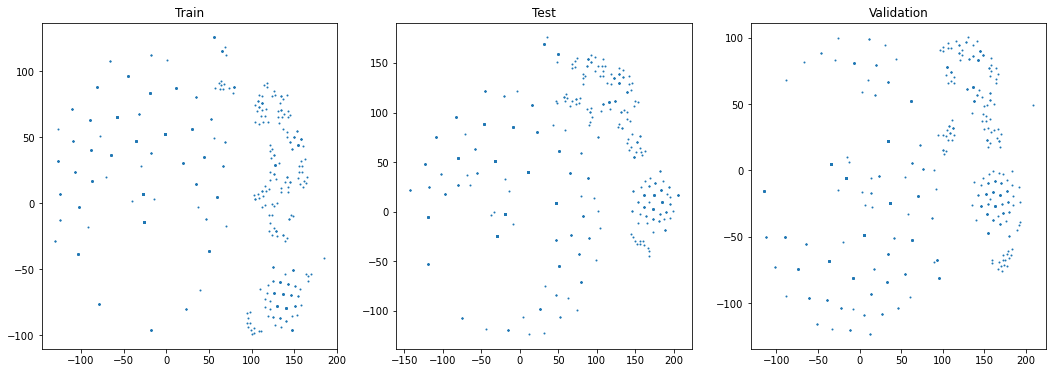

In [25]:
if encoded_dim > 2:
    from sklearn import manifold
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    train_x_tsne = tsne.fit_transform(train_x_latent[:2000])
    test_x_tsne = tsne.fit_transform(test_x_latent[:2000])
    val_x_tsne = tsne.fit_transform(val_x_latent[:2000])
    plot_2d_data( [train_x_tsne, test_x_tsne, val_x_tsne],
            ['Train','Test', 'Validation'],(18,6))

In [26]:
if encoded_dim == 2:
    plot_2d_data([train_x_latent,val_x_latent,test_x_latent],['Train','Validation','Test'],(18,6))

In [27]:
reconstruction_train = cvae.predict([train_x_flatten[:5000],train_y_one_hot[:5000]])
#reconstruction_test = cvae.predict([test_x_flatten,test_y_one_hot])
#reconstruction_val = cvae.predict([val_x_flatten,val_y_one_hot])
image_count = 10



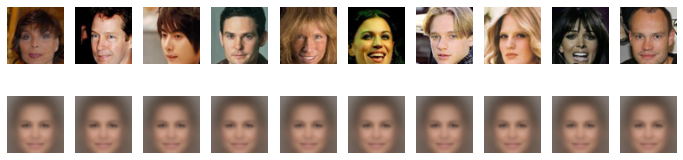

In [28]:
fig, axs = plt.subplots(2, image_count, figsize=(12, 3))
for i in range(image_count):
  random_idx = random.randint(0, reconstruction_train.shape[0])
  axs[0, i].imshow(train_x[random_idx])
  axs[0, i].axis('off')
  #axs[0, i].set_title(train_y[random_idx])
  #axs[0, i].set_title( labels[int(train_y[random_idx])]  )
  axs[1, i].imshow(reconstruction_train[random_idx].reshape(original_image_shape))
  axs[1, i].axis('off')
  wandb.log({"Reconstructions": wandb.Image(plt)})

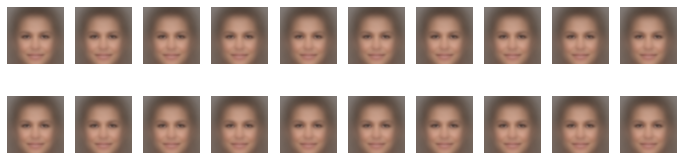

In [29]:
import tensorflow as tf
target_attr = [2, 9, 12, 21, 26, 27, 31, 39]
image_count = 10

_, axs = plt.subplots(2, image_count, figsize=(12, 3))
for j in range(2):
    for i in range(image_count):

        attr_vect = np.zeros(40)
        for attr in target_attr:
            attr_vect[attr] = 1

        random_sample = tf.random.normal(shape = (1, encoded_dim))
        digit_label_one_hot= np.array([attr_vect], dtype='float32')


        decoded_x = cvae_decoder.predict([random_sample,digit_label_one_hot])
        digit = decoded_x[0].reshape(original_image_shape)
        axs[j, i].imshow(digit)
        axs[j, i].axis('off')

        attributes = str(df.columns[target_attr].tolist())
wandb.log(   {"Generations:_{}".format(attributes): wandb.Image(plt)}     )

In [30]:
random_sample = np.array([[random.normalvariate(0,1), random.normalvariate(0,1)]])
random_sample.shape

(1, 2)

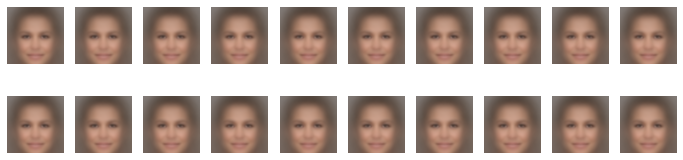

In [31]:
target_attr = [0, 4, 8, 15, 20]
image_count = 10

_, axs = plt.subplots(2, image_count, figsize=(12, 3))
for j in range(2):
    for i in range(image_count):

        attr_vect = np.zeros(40)
        for attr in target_attr:
            attr_vect[attr] = 1

        random_sample = tf.random.normal(shape = (1, encoded_dim))
        digit_label_one_hot= np.array([attr_vect], dtype='float32')


        decoded_x = cvae_decoder.predict([random_sample,digit_label_one_hot])
        digit = decoded_x[0].reshape(original_image_shape)
        axs[j, i].imshow(digit)
        axs[j, i].axis('off')

        attributes = str(df.columns[target_attr].tolist())
wandb.log(   {"Generations:_{}".format(attributes): wandb.Image(plt)}     )

In [32]:
wandb.finish(exit_code=0, quiet = True) # TEMPORARY